In [2]:
import torch
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
from sklearn.metrics import pairwise_distances_chunked
import matplotlib.pyplot as plt
from transformer_lens import HookedTransformer
from sae_lens import SAE

import numpy as np
import random

/Users/plato/code/boc/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
df = pd.read_csv('data/questions.csv')
df = df.sample(frac=0.01, random_state=42).reset_index(drop=True)
print(df.shape)
print(df['is_duplicate'].value_counts())

(4044, 6)
is_duplicate
0    2577
1    1467
Name: count, dtype: int64


In [74]:

device = 'cpu'
model = HookedTransformer.from_pretrained("gpt2-small", device = device)

sae_id = "blocks.8.hook_resid_pre"
sae, cfg_dict, sparsity = SAE.from_pretrained(
    release = "gpt2-small-res-jb", # see other options in sae_lens/pretrained_saes.yaml
    sae_id = sae_id,
    device = device
)

/Users/plato/code/boc/.venv/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Loaded pretrained model gpt2-small into HookedTransformer


/Users/plato/code/boc/.venv/lib/python3.11/site-packages/sae_lens/sae.py:136: UserWarning: 
This SAE has non-empty model_from_pretrained_kwargs. 
For optimal performance, load the model like so:
model = HookedSAETransformer.from_pretrained_no_processing(..., **cfg.model_from_pretrained_kwargs)
  warnings.warn(


In [4]:
# Assuming df is your DataFrame with 'question1' and 'question2' columns
docs = df['question1'].tolist() + df['question2'].tolist()
print(f"Total documents before deduplication: {len(docs)}")

# Remove duplicates to get unique documents
docs = list(set(docs))
print(f"Total unique documents: {len(docs)}")

Total documents before deduplication: 8088
Total unique documents: 7984


In [76]:
batch_size = 32

feature_acts = None
all_att_mask = None
for i in range(0, len(docs), batch_size):
    print(i)
    batch = docs[i:i+batch_size]
    inputs = model.tokenizer(batch, return_tensors='pt', padding='max_length', truncation=True, max_length=90)
    _, cache = model.run_with_cache(inputs.input_ids, attention_mask=inputs.attention_mask, prepend_bos=True, stop_at_layer=9)
    f_acts = sae.encode(cache[sae.cfg.hook_name])
    if feature_acts is None:
        feature_acts = f_acts
        all_att_mask = inputs.attention_mask
    else:
        feature_acts = torch.cat((feature_acts, f_acts), dim=0)
        all_att_mask = torch.cat((all_att_mask, inputs.attention_mask), dim=0)

0
32
64
96
128
160
192
224
256
288
320
352
384
416
448
480
512
544
576
608
640
672
704
736
768
800
832
864
896
928
960
992
1024
1056
1088
1120
1152
1184
1216
1248
1280
1312
1344
1376
1408
1440
1472
1504
1536
1568
1600
1632
1664
1696


: 

In [ ]:
def to_concept_documents(documents, feature_acts, attention_mask, k=5):
    assert len(documents) == feature_acts.shape[0], f"Expected {len(documents)} documents, got {feature_acts.shape[0]}"

    concept_docs = []
    for i, doc in enumerate(documents):
        actual_tokens = feature_acts[i][attention_mask[i]]

        topk = torch.topk(actual_tokens, k, dim=1).indices

        tokens = []
        for idx in topk:
            tokens.extend([str(i.item()) for i in idx])

        concept_docs.append(" ".join(tokens))

    return concept_docs

def get_auc(df, docs, thresholds, cds):
    # Create a mapping from document text to index
    doc_to_index = {doc: idx for idx, doc in enumerate(docs)}

    # Map 'question1' and 'question2' to their indices
    df['q1idx'] = df['question1'].map(doc_to_index)
    df['q2idx'] = df['question2'].map(doc_to_index)

    # Build the mapping from q1idx to q2idx and vice versa
    mapping = dict(zip(df['q1idx'], df['q2idx']))
    mapping.update(zip(df['q2idx'], df['q1idx']))

    if cds is not None:
        docs = cds

    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(docs)

    q1_list = np.array(list(mapping.keys()))
    q2_list = np.array([mapping[q1] for q1 in q1_list])

    query_texts = [docs[q1] for q1 in q1_list]
    query_vectors = vectorizer.transform(query_texts)

    results = []

    batch_size = 10_000  # Adjust this based on your memory constraints

    for threshold in thresholds:
        n_queries = query_vectors.shape[0]
        n_batches = int(np.ceil(n_queries / batch_size))
        n_above_threshold_total = np.zeros(n_queries, dtype=int)
        n_correct_above_threshold_total = np.zeros(n_queries, dtype=int)
        
        for batch_idx in range(n_batches):
            start = batch_idx * batch_size
            end = min((batch_idx + 1) * batch_size, n_queries)
            
            query_batch = query_vectors[start:end]
            
            chunk_generator = pairwise_distances_chunked(
                X=query_batch,
                Y=tfidf_matrix,
                metric='cosine',
                n_jobs=-1,
                working_memory=2048 # Adjust this based on your system
            )
            
            for chunk in chunk_generator:
                cosine_sim_batch = 1 - chunk
                
                for i in range(cosine_sim_batch.shape[0]):
                    idx = start + i
                    sim_scores = cosine_sim_batch[i]
                    
                    n_above = np.sum(sim_scores > threshold)
                    n_above_threshold_total[idx] = n_above
                    
                    correct_doc_idx = q2_list[idx]
                    correct_sim = sim_scores[correct_doc_idx]
                    n_correct_above = int(correct_sim > threshold)
                    n_correct_above_threshold_total[idx] = n_correct_above
                    
        with np.errstate(divide='ignore', invalid='ignore'):
            scores = np.divide(
                n_correct_above_threshold_total,
                n_above_threshold_total,
                where=n_above_threshold_total > 0
            )
            scores[n_above_threshold_total == 0] = 0

        # Compute average score for the current threshold
        avg_score = np.mean(scores)
        results.append(avg_score)
    return results


In [ ]:
rs = []
ks = [None, 1, 2, 4, 8, 16]

thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 0.9]

for k in ks:
    if k is None:
        cds = None
    else:
        cds = to_concept_documents(docs, feature_acts, attention_mask=all_att_mask.to(torch.bool), k=k)
        print('got concept documents', cds[:4])

        
    results = get_auc(df, docs, thresholds, cds=cds)
    print('got results documents')

    rs.append(results)

got results documents
got concept documents ['11746 4252 17949 19230 633 2126 12660 21628 16125 8258 15778', '11746 24395 23763 3895 6559 12826 16005 8462 1055 9744 15255 15778', '11746 22657 17664 8883 15310 7736 2051 2204 1616', '11746 17495 22766 1957 24081 17057 16968 9867 1957 1957 14505 18342 20288 799 10868 12024']
got results documents
got concept documents ['11746 11533 4252 14817 17949 15926 19230 24412 633 23139 2126 7758 12660 23488 21628 23258 16125 21322 8258 4230 15778 16005', '11746 11533 24395 10932 23763 16664 3895 19998 6559 8630 12826 14901 16005 12024 8462 17927 1055 22657 9744 24330 15255 18456 15778 22607', '11746 11533 22657 7920 17664 14666 8883 16185 15310 495 7736 4796 2051 17565 2204 8200 1616 16005', '11746 11533 17495 4249 22766 21153 1957 4460 24081 22601 17057 13272 16968 24473 9867 12417 1957 16472 1957 15616 14505 23460 18342 18654 20288 6338 799 5576 10868 3187 12024 11413']
got results documents
got concept documents ['11746 11533 4078 13997 4252 148

In [ ]:
f, ax = plt.subplots(1, len(rs), figsize=(10, 6))

# 0.035
for i, r in enumerate(rs):
    ax[i].plot(thresholds, r, marker='o')
    ax[i].set_title(f"AUC for k={ks[i]}")

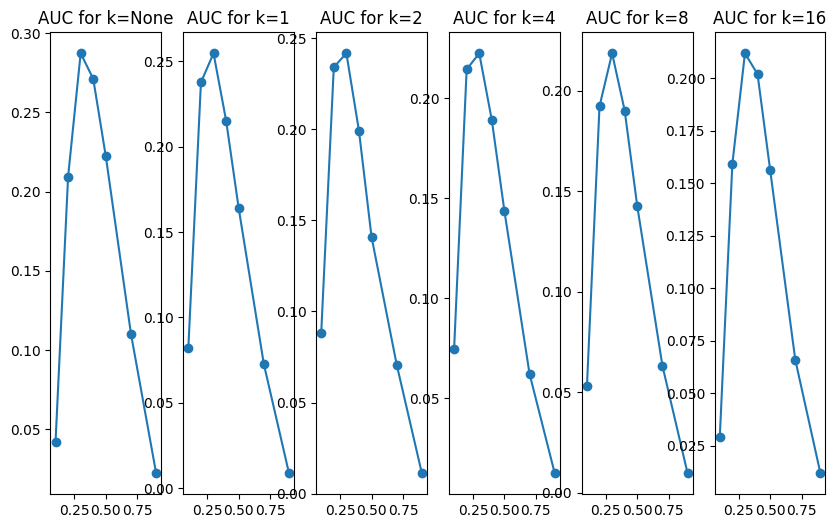

In [72]:
f, ax = plt.subplots(1, len(rs), figsize=(10, 6))

# 0.035
for i, r in enumerate(rs):
    ax[i].plot(thresholds, r, marker='o')
    ax[i].set_title(f"AUC for k={ks[i]}")